In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

2025-11-04 19:06:00.163595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762283160.470539      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762283160.551669      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Dataset Setup

In [2]:
dataset_train_path = r"/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
dataset_valid_path = r"/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 2. Data Preprocessing & Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    dataset_valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print("Detected Classes:", class_labels)




Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Detected Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_

# 3. Model Definition (Transfer Learning)

In [4]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


2025-11-04 19:06:52.072822: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 4. Compile Model

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,596,710 (9.91 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

# 5. Callbacks

In [6]:
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)



# 6. Train Model

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5057 - loss: 1.9006
Epoch 1: val_accuracy improved from -inf to 0.87178, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1780s 807ms/step - accuracy: 0.5058 - loss: 1.9002 - val_accuracy: 0.8718 - val_loss: 0.4479
Epoch 2/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8474 - loss: 0.5180
Epoch 2: val_accuracy improved from 0.87178 to 0.90217, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1644s 748ms/step - accuracy: 0.8474 - loss: 0.5179 - val_accuracy: 0.9022 - val_loss: 0.3157
Epoch 3/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8786 - loss: 0.3880
Epoch 3: val_accuracy improved from 0.90217 to 0.92050, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1622s 738ms/step - accuracy: 0.8786 - loss: 0.3880 - val_accuracy: 0.9205 - val_loss: 0.2581
Epoch 4/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8970 - loss: 0.3253
Epoc

# 7. Plot Accuracy and Loss

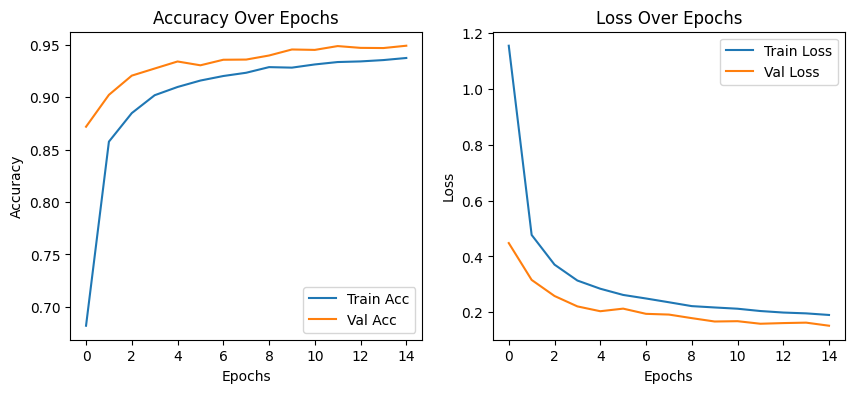

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

plt.savefig('accuracy_and_loss_over_epochs.png')
plt.show()

# 8. Evaluation

550/550 ━━━━━━━━━━━━━━━━━━━━ 357s 646ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.95      0.96       504
                                 Apple___Black_rot       0.98      0.99      0.99       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.98       440
                                   Apple___healthy       0.97      0.98      0.98       502
                               Blueberry___healthy       1.00      0.97      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.98       421
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.94      0.91       410
                       Corn_(maize)___Common_rust_       0.95      1.00      0.98       477
          

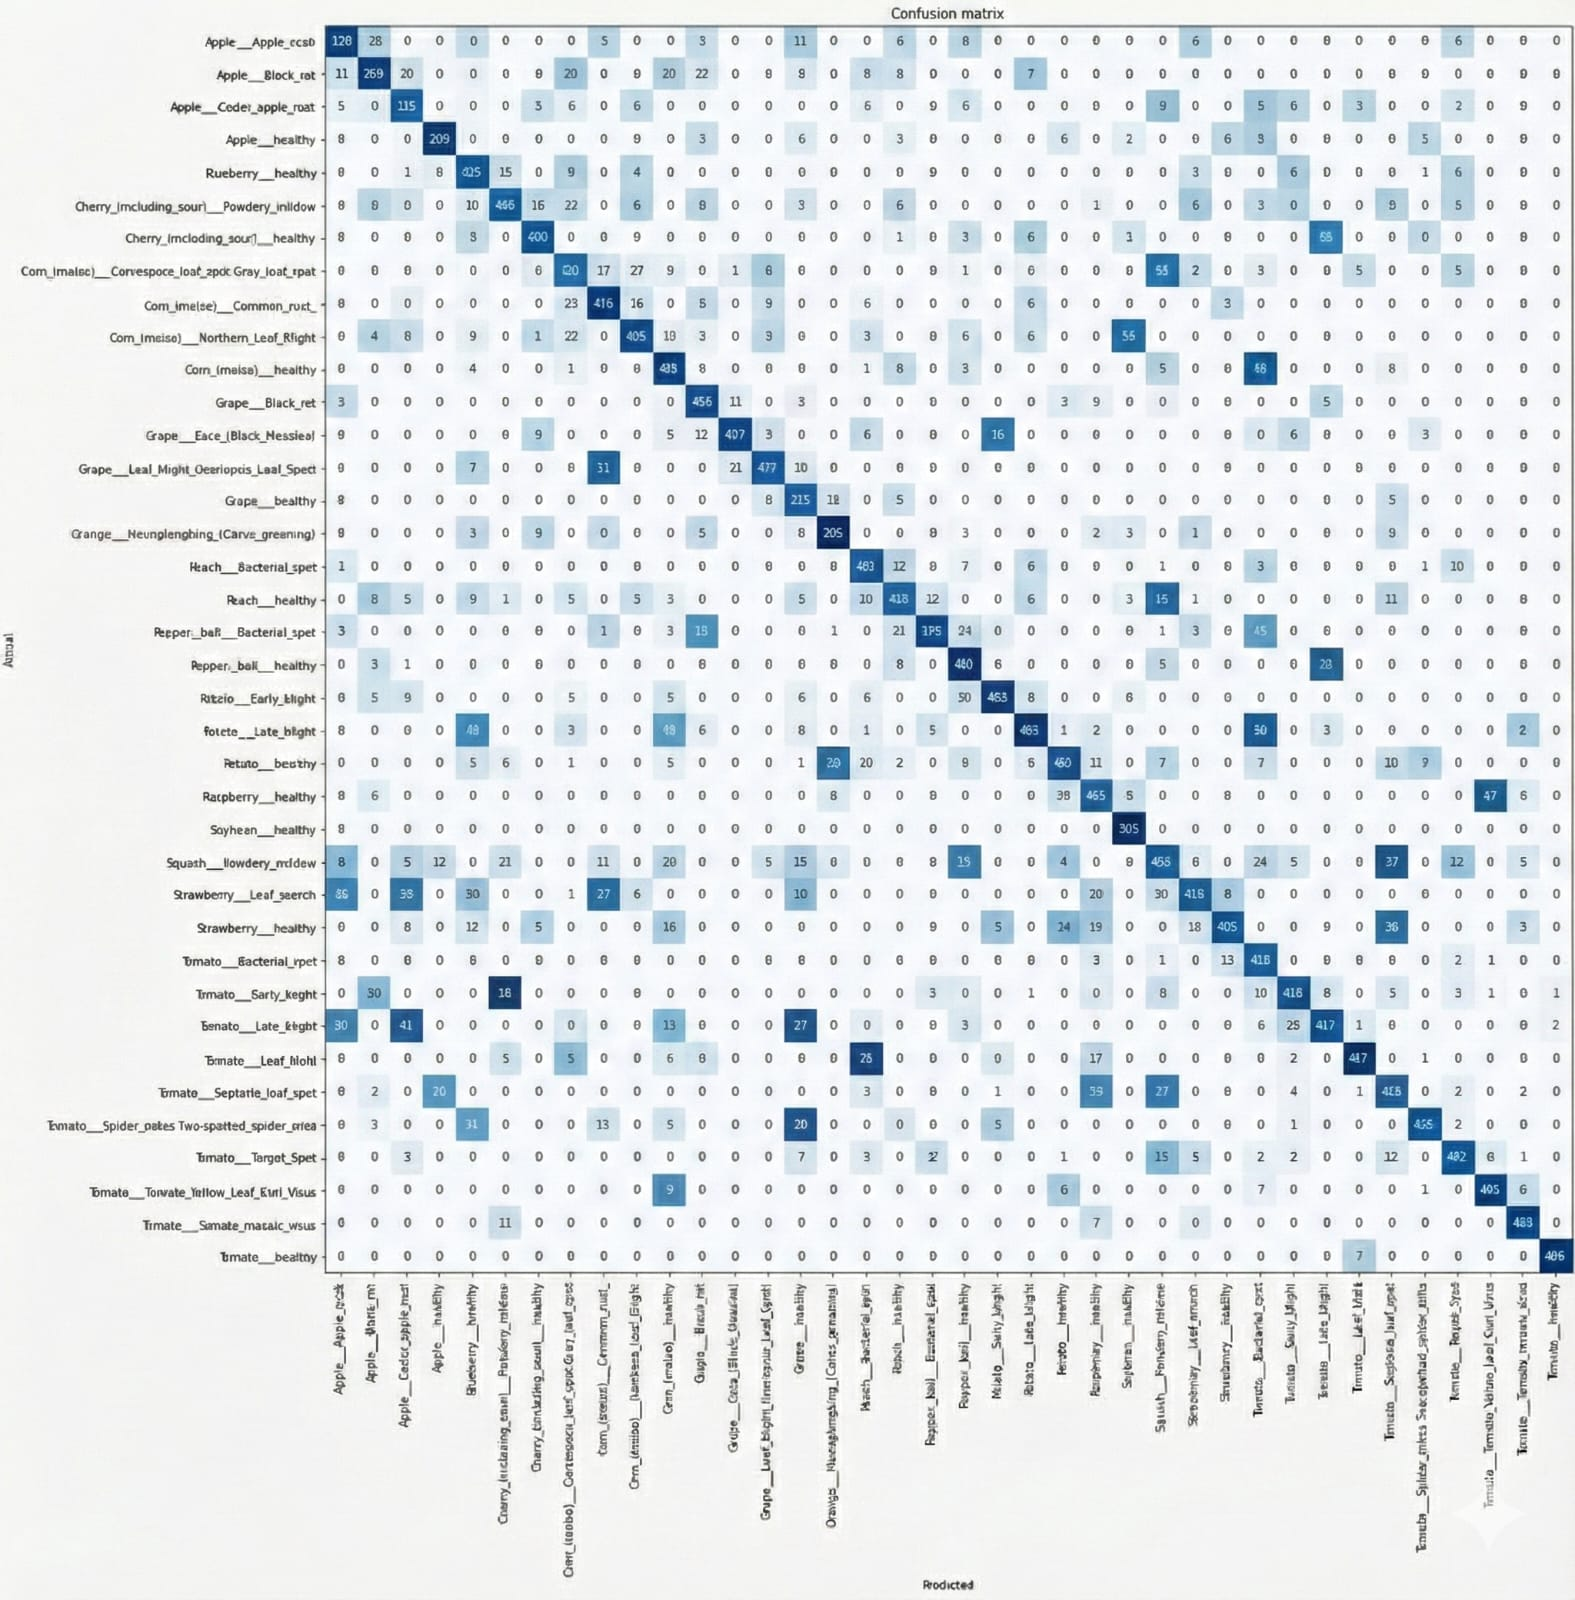

In [ ]:
import seaborn as sns

val_generator.reset()
preds = model.predict(val_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = val_generator.classes

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 9. ROC-AUC Curve Calculation


Overall ROC-AUC Score: 0.9994


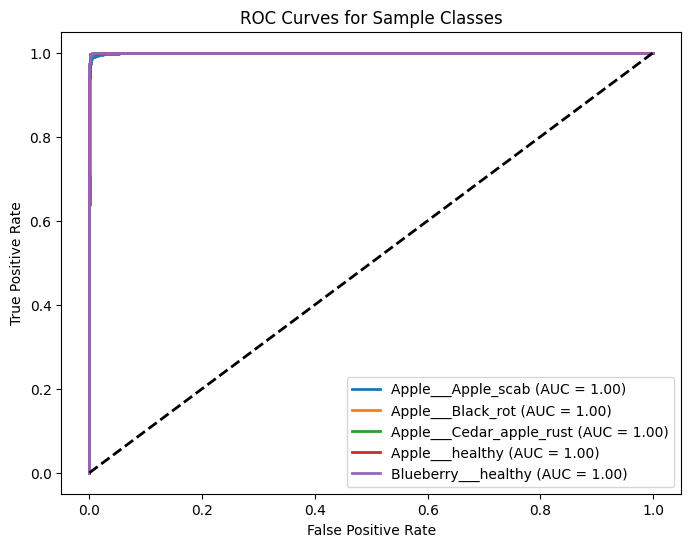

In [10]:
# Convert labels to one-hot encoding
true_classes_onehot = label_binarize(true_classes, classes=range(num_classes))

# Compute overall macro-average ROC-AUC
roc_auc = roc_auc_score(true_classes_onehot, preds, average='macro')
print(f"\nOverall ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curves for first few classes (up to 5 for clarity)
plt.figure(figsize=(8, 6))
for i in range(min(num_classes, 5)):
    fpr, tpr, _ = roc_curve(true_classes_onehot[:, i], preds[:, i])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sample Classes')
plt.legend(loc='lower right')
plt.show()


# 10. Grad-CAM Visualization
Visualizing which parts of the image the model focuses on for classification.

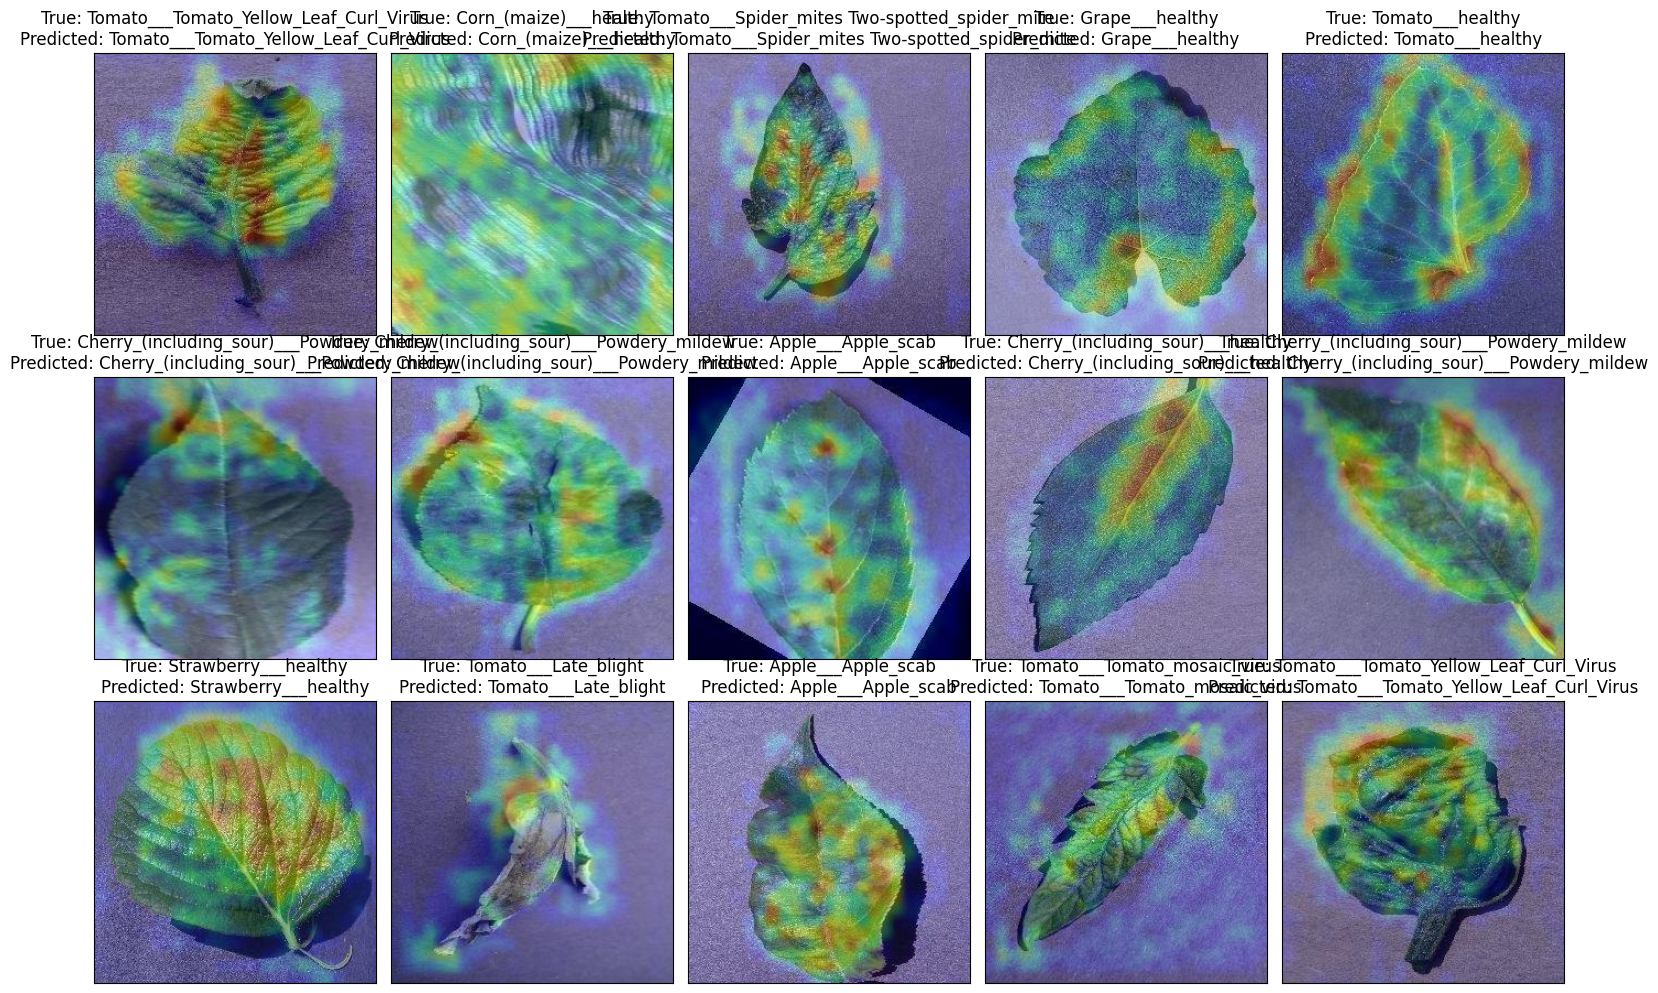

In [ ]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # Since our model is Sequential wrapping a Functional base_model, we need to reconstruct the flow
    
    nested_base_model = model.layers[0] # MobileNetV2
    
    # Create a new model that outputs the last conv layer of base_model AND the final prediction
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = nested_base_model(inputs) # Output of MobileNetV2 (7x7x1280)
    
    # Pass through the rest of the model layers
    y = x
    for layer in model.layers[1:]:
        y = layer(y)
        
    grad_model = tf.keras.models.Model(inputs=inputs, outputs=[x, y])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="gradcam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img.astype('uint8') / 255.0)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

# --- Run Grad-CAM on a sample image ---
# Get a sample image from validation set
img_path = val_generator.filepaths[0] 
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0 # Normalize

# Generate heatmap
# Note: We don't need 'last_conv_layer_name' because we access the layer directly in the function logic above
heatmap = make_gradcam_heatmap(img_array, model, "unused_param")

save_and_display_gradcam(img_path, heatmap)

# 11. Save Final Model

In [11]:
model.save("plant_disease_mobilenetv2_final.keras")
print("\n✅ Model training complete and saved successfully!")


✅ Model training complete and saved successfully!
